In [44]:
from __future__ import division
import re
import argparse
import os


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import callbacks as callbacks
from tensorflow.keras.callbacks import Callback

from keras_frcnn import config
from keras_frcnn import losses as losses
from keras_frcnn import resnet as nn
from keras_frcnn import train_helpers
from keras_frcnn.dual_frcnn import Dual_FRCNN
from keras_frcnn.frcnn import FRCNN
from keras_frcnn import CLIP
from keras_frcnn import roi_helpers


from keras_frcnn.tfrecord_parser import get_data
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

In [3]:
# pass the settings from the command line, and persist them in the config object
C = config.Config()

C.model_path = r"C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\ZSL\outputs\model\ZSL_FRCNN_fine_tune_epoch-total_loss-2.23.hdf5"
C.train_path = r"C:\Data_drive\Data"
model_type = 'ZSL'


model_path_regex = re.match("^(.+)(\.hdf5)$", C.model_path)
if model_path_regex.group(2) != '.hdf5':
    print('Output weights must have .hdf5 filetype')
    exit(1)


train_dataset, total_train_records = get_data('train', C)
val_dataset, total_val_records = get_data('test', C)

C.class_mapping = train_helpers.get_class_map(C)

C.class_text = train_helpers.get_class_text(C)

#find the largest class id and add 1 for the background class
num_ids = C.class_mapping[max(C.class_mapping, key=C.class_mapping.get)] + 1

print(f'Num train samples {total_train_records}')
print(f'Num val samples {total_val_records}')

#since we are using square images, we know the image size we will be scaling to
input_shape_img = (C.im_size, C.im_size, 3)
roi_input = Input(shape=(C.num_rois, 4))

print('Building models.')
# define the base network (resnet here)
base_model = ResNet50(input_shape = input_shape_img, weights='imagenet', include_top=False)

#freeze the feature extractor
base_model.trainable = False

shared_layers = Model(inputs=base_model.inputs, outputs=base_model.get_layer('conv4_block6_out').output)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = nn.rpn(shared_layers.output, num_anchors)
model_rpn = Model(shared_layers.input, rpn[:2])
optimizer = Adam()

if model_type == 'ZSL':
    classifier_ZSL = nn.classifier_ZSL(shared_layers.output, roi_input, C.num_rois, C.num_projection_layers, C.projection_dims, C.dropout_rate, nb_classes=num_ids, trainable=True)
    # this is a model that holds both the RPN and the classifier, used to train the model end to end
    model_all = Model([shared_layers.input, roi_input], rpn[:2] + classifier_ZSL)
    #build the text encoder
    text_encoder = CLIP.create_text_encoder(C)
else:
    classifier = nn.classifier(shared_layers.output, roi_input, C.num_rois, nb_classes=num_ids, trainable=True)
    # this is a model that holds both the RPN and the classifier, used to train the model end to end
    model_all = Model([shared_layers.input, roi_input], rpn[:2] + classifier)

if model_type == 'ZSL':
    Dual_FRCNN = Dual_FRCNN(model_rpn, model_all, text_encoder, C)
    Dual_FRCNN.compile(optimizer= optimizer, run_eagerly = True)
    
print('Models sucessfully built.')

try:
    if (C.model_path == None):
        print('Loaded imagenet weights to the vision backbone.')
    else:
        print(f'loading RCNN weights from {C.model_path}')
        model_all.load_weights(C.model_path, by_name=True)
    if model_type == 'ZSL':
        print(f'loading text encoder weights from {C.model_path}')
        text_encoder.load_weights(C.model_path, by_name=True)

except:
    print('Could not load pretrained model weights.')

Parsing annotation files
total records in the TFrecord file is : 132
Parsing annotation files
total records in the TFrecord file is : 39
Num train samples 132
Num val samples 39
Building models.
Models sucessfully built.
loading RCNN weights from C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\ZSL\outputs\model\ZSL_FRCNN_fine_tune_epoch-total_loss-2.23.hdf5
loading text encoder weights from C:\Data_drive\Github\GEOINT_Zero-shot_Object_identification\notebooks\ZSL\outputs\model\ZSL_FRCNN_fine_tune_epoch-total_loss-2.23.hdf5


# Embed the text strings

In [4]:
labels = []
for key in C.class_text:
    labels.append(C.class_text[key])

In [5]:
print(f"Generating embeddings for {len(labels)} labels...")
text_embeddings = text_encoder.predict(tf.convert_to_tensor(labels))
#normalize the text embedding
#text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1)

print(f"Text embeddings shape: {text_embeddings.shape}.")

Generating embeddings for 61 labels...
Image embeddings shape: (61, 256).


# Embed the image

In [69]:
test_image_path = r'C:\Data_drive\Data\inference\5.jpg'

image_array = tf.image.decode_jpeg(tf.io.read_file(test_image_path), channels=3)
image_array = tf.image.resize(image_array, (C.im_size, C.im_size))

image_tensor = tf.convert_to_tensor(image_array)

#reshape because the first dimension is batch size
image_tensor = image_tensor[None,:,:,:]

P_rpn = model_rpn.predict(image_tensor)

#regions_of_interest input and output are in feature space
regions_of_interest = roi_helpers.rpn_to_roi(C, P_rpn[0], P_rpn[1], use_regr=True, overlap_thresh=0.1, max_boxes=C.num_rois)

roi_tensor = tf.convert_to_tensor(regions_of_interest)
#reshape because the first dimension is batch size
roi_tensor = roi_tensor[None,:,:]

model_preds = model_all.predict([image_tensor, roi_tensor])

#image_embeddings /= tf.math.l2_normalize(image_embeddings, axis=1)

print(f"Image embeddings shape: {model_preds[2][0].shape}.")

Image embeddings shape: (25, 256).


# Find the similarity

In [46]:
#for roi in range(model_preds[2][0].shape[0])
    
dot_similarity = tf.matmul(100 * text_embeddings, model_preds[2][0], transpose_b=True)
true_probs = tf.keras.activations.softmax(dot_similarity, axis=0)

In [59]:
results = tf.math.top_k(tf.transpose(dot_similarity), 5).indices.numpy()
probs = tf.math.top_k(tf.transpose(true_probs), 5).values.numpy()

# Show the image

(-0.5, 499.5, 499.5, -0.5)

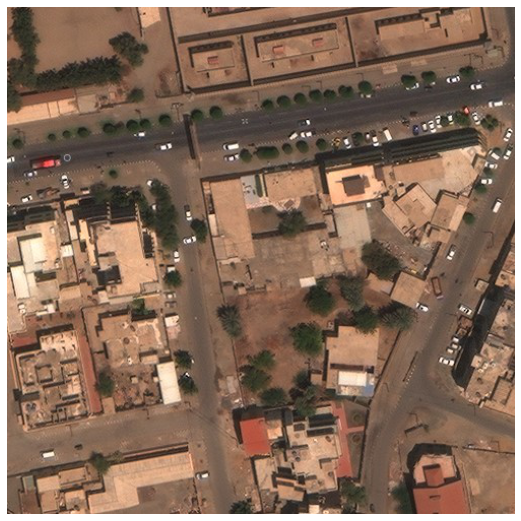

In [66]:
from PIL import Image
import matplotlib.pyplot as plt
image = Image.open(test_image_path).convert("RGB")

#set the image size
plt.figure(figsize=(20, 10))


#show the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")

In [115]:
def draw_boxes(image, bboxes, labels, probs):
    import cv2
    import matplotlib.pyplot as plt

    window_name = 'Image'

    image = np.copy(image)


    # font needed for text
    font = cv2.FONT_HERSHEY_SIMPLEX

    
    for box in range(bboxes.shape[0]):

        x1 = bboxes[box][0] * C.im_size / P_rpn[1].shape[1]
        y1 = bboxes[box][1] * C.im_size / P_rpn[1].shape[2]
        x2 = bboxes[box][2] * C.im_size / P_rpn[1].shape[1]
        y2 = bboxes[box][3] * C.im_size / P_rpn[1].shape[2]

        topleft = (int(x1), int(y1))
        bottomright = (int(x2), int(y2))

        #This is the truth
        image = cv2.rectangle(image, topleft, bottomright, color=(0, 0, 255), thickness=1)
        # Display the image 

    plt.figure(figsize=(20, 10))
    plt.imshow(image) 

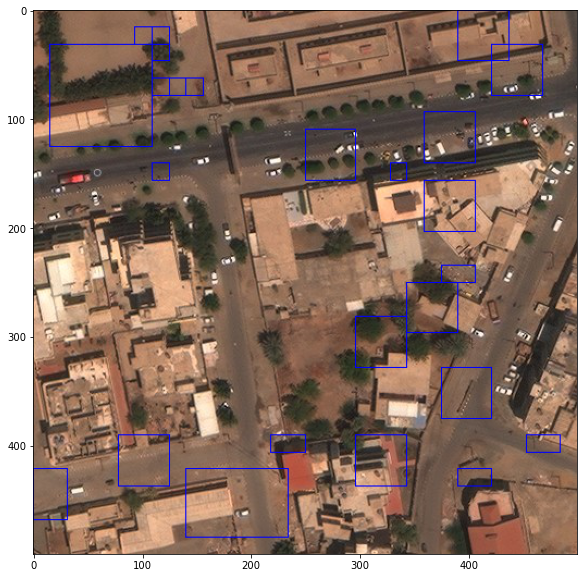

In [116]:
draw_boxes(image, regions_of_interest, labels, probs)

TypeError: only size-1 arrays can be converted to Python scalars

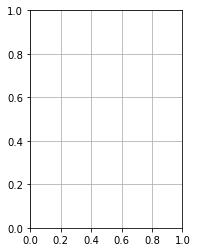

In [104]:
#show the probabilities
plt.subplot(1, 2, 2)
for i in range(len(probs)):
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in results])
    plt.xlabel("probability")

plt.show()